In [3]:
import numpy as np
import pandas as pd
import zipfile
import cv2
import os
import io
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.nn.utils.clip_grad import clip_grad_norm_
from torchvision import transforms as T
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [4]:
# with zipfile.ZipFile("CCPD2019-dl1.zip", 'r') as zf:
#     zf.extractall("")

# os.mkdir("CCPD2019-dl1/val/")
# train_filenames = os.listdir("CCPD2019-dl1/train")

# train_filenames, val_filenames = train_test_split(train_filenames, test_size=0.15, shuffle=True, random_state=42)

# for filename in val_filenames:
#     os.rename("CCPD2019-dl1/train/" + filename, "CCPD2019-dl1/val/" + filename)
    


In [5]:
# for split in "val", "test":
#     for filename in os.listdir("CCPD2019-dl1/" + split):
#         os.remove(f"CCPD2019-dl1/{split}/{filename}")
#     os.rmdir(f"CCPD2019-dl1/{split}")
# os.rmdir(f"CCPD2019-dl1")

In [6]:
# with zipfile.ZipFile("CCPD.zip", "w") as zf:
#     for dirname, subdirs, files in os.walk("CCPD2019-dl1"):
#         zf.write(dirname)
#         for filename in tqdm(files):
#             zf.write(os.path.join(dirname, filename))

In [7]:
img_shape = (128, 400)

train_tfms = T.Compose([
    T.ToTensor(),
    T.ConvertImageDtype(torch.uint8),
    T.CenterCrop(img_shape),
])

test_tfms = T.Compose([
    T.ToTensor(),
    T.ConvertImageDtype(torch.uint8),
    T.CenterCrop(img_shape),
])

In [8]:
def label_filter(name):
    return name[name.find("-", 9) + 1:-4].encode('cp437').decode('utf-8')

In [9]:
# provinces = set([label_filter(num)[0] for num in train_dataset.name_list])

provinces = ["京", "皖", "甘", "陇", "粤", "黔", "贵", "辽", "川", "津", "闽", "琼", "鄂", "湘", "冀", "黑", "豫", "吉", "赣",
                 "苏", "青", "浙", "渝", "沪", "鲁", "晋", "陕", "秦", "滇", "云", "藏", "桂", "蒙", "宁", "新", "港", "澳", "台"]

vocab = [chr(idx) for idx in list(range(ord("A"), ord("Z") + 1)) + list(range(ord("0"), ord("9") + 1))]

In [10]:
province_map = {province: idx for idx, province in enumerate(provinces)}
symbol_map = {symbol: idx for idx, symbol in enumerate(vocab)}

province_map_rev = {idx: province for idx, province in enumerate(provinces)}
symbol_map_rev = {idx: symbol for idx, symbol in enumerate(vocab)}


vocab_len_1 = len(provinces)
vocab_len_2 = len(vocab)

In [11]:
class ZipDataset(Dataset):
    def __init__(self, path, label_filter=None, prefix="", transform=None):
        f = open(path, 'rb')
        self.zip_content = f.read()
        f.close()
        self.zip_file = zipfile.ZipFile(io.BytesIO(self.zip_content), 'r')
        self.label_filter = label_filter
        self.prefix = prefix
        self.name_list = list(filter(lambda filename: filename.endswith(".jpg") and filename.startswith(self.prefix),
                              self.zip_file.namelist()))
        self.transform = transform

    def __getitem__(self, key):
        name = self.name_list[key]
        buf = self.zip_file.read(name=name)
        img = cv2.imdecode(np.frombuffer(buf, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        if self.transform is not None:
            img = self.transform(img)
        if self.label_filter:
            name = label_filter(name)
        return img, name
    
#     def collate_fn(self, key):
        
        
    def convert_label(name):
        if self.label_filter:
            name = label_filter(name)
        return province_map[name[0]], [symbol_map[symbol] for symbol in name[1:]]

    def __len__(self):
        return len(self.name_list)


In [12]:
batch_size = 96
train_dataset = ZipDataset('CCPD2019-dl1.zip', prefix="CCPD2019-dl1/train", label_filter=label_filter, transform=train_tfms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ZipDataset('CCPD2019-dl1.zip', prefix="CCPD2019-dl1/val", label_filter=label_filter, transform=test_tfms)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ZipDataset('CCPD2019-dl1.zip', prefix="CCPD2019-dl1/test", label_filter=label_filter, transform=test_tfms)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding_1 = nn.Linear(nHidden * 2, nOut[0])
        self.embedding_2 = nn.Linear(nHidden * 2, nOut[1])
        
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        recurrent = [recurrent[0], recurrent[1:]]
        T, b, h = recurrent[1].size()
        t_rec = recurrent[1].view(T * b, h)
        output = [self.embedding_1(recurrent[0]).view(1, b, -1), self.embedding_2(t_rec).view(T, b, -1)]  # [T * b, nOut]
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d((2, 2), 2))
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d((2, 2), 2))
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))
        convRelu(6, True)
        
        self.cnn = cnn
#         self.rnn = nn.Sequential(
#             BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nHidden']),
#             BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses'])
#         )
        
        self.rnn = BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nClasses'])
        self.linear_h = nn.Linear(7, 1)
        self.linear_w = nn.Linear(101, 7)
        


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        
#         print(conv.size())
        conv = self.linear_w(conv)
#         print(conv.size())
        conv = conv.permute(0, 1, 3, 2)
        conv = self.linear_h(conv)
        conv = conv.permute(0, 1, 3, 2)
        b, c, h, w = conv.size()
#         print(conv.size())
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output[0] = output[0].squeeze()
        output[1] = output[1].transpose(1,0) #Tbh to bth
        return output

In [14]:
args = {
    'name':'exp1',
    'path':'data',
    'imgdir': 'train',
    'imgH':128,
    'nChannels':1,
    'nHidden':256,
    'nClasses': (vocab_len_1, vocab_len_2),
    'lr':0.001,
    'epochs':4,
    'batch_size':96,
    'save_dir':'checkpoints',
    'log_dir':'logs',
    'resume':False,
    'cuda':True,
    'schedule':False
    
}
device = torch.device("cuda")
model = CRNN(args).to(device)
num_criterion = nn.CTCLoss(reduction="mean", zero_infinity=True)
province_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args['lr'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args['epochs'])


In [15]:
y_val = torch.Tensor().to(dtype=torch.int8)
for batch in tqdm(val_dataloader):
    b_labels = torch.LongTensor(
            [[symbol_map[symbol] for symbol in batch[1][i][1:]]
             for i in range(len(batch[1]))])
    y_val = torch.cat((y_val, b_labels.view(-1)))

  0%|          | 0/313 [00:00<?, ?it/s]

In [16]:
y_test = torch.Tensor().to(dtype=torch.int8)
for batch in tqdm(test_dataloader):
    b_labels = torch.LongTensor(
            [[symbol_map[symbol] for symbol in batch[1][i][1:]]
             for i in range(len(batch[1]))])
    y_test = torch.cat((y_test, b_labels.view(-1)))

  0%|          | 0/105 [00:00<?, ?it/s]

In [17]:
print("Validation:")
model.eval()

start = time.time()
predictions = torch.Tensor().to(dtype=torch.int8)
val_loss = 0

for batch in tqdm(val_dataloader):

    b_input = batch[0].to(device)
    b_labels = torch.LongTensor(
        [[symbol_map[symbol] for symbol in batch[1][i][1:]]
         for i in range(len(batch[1]))]
    ).to(device)

    with torch.no_grad():
        logits = model(b_input / 255).transpose(0, 1)
        logits = F.log_softmax(logits, 2)
        pred_sizes = (torch.ones(len(batch[0])) * 6).long().to(device)

        loss = criterion(logits, b_labels, pred_sizes, pred_sizes)

    predictions = torch.cat((predictions, logits.transpose(0, 1).argmax(dim=-1).view(-1).cpu().detach()))
    torch.cuda.empty_cache()

print("Mean loss: " , val_loss / len(val_dataloader))
print("Accuracy {:4.2f}".format(accuracy_score(y_val, predictions.view(-1))))
val_losses.append(val_loss / len(val_dataloader))
print("Validation took: {:}".format(timedelta(seconds = int(time.time() - start))))
print()

Validation:


  0%|          | 0/313 [00:00<?, ?it/s]

Mean loss:  0.0
Accuracy 0.99
Validation took: 0:02:53



In [47]:
print("Testing:")
model.eval()

start = time.time()
test_predictions = torch.Tensor().to(dtype=torch.int8)

for batch in tqdm(test_dataloader):

    b_input = batch[0].to(device)
    b_labels = torch.LongTensor(
        [[symbol_map[symbol] for symbol in batch[1][i][1:]]
         for i in range(len(batch[1]))]
    ).to(device)

    with torch.no_grad():
        logits = model(b_input / 255)

    test_predictions = torch.cat((test_predictions, logits.argmax(dim=-1).view(-1).cpu().detach()))

print("Accuracy {:4.2f}".format(accuracy_score(y_test, test_predictions.view(-1))))
print("Testing took: {:}".format(timedelta(seconds = int(time.time() - start))))
print()

Accuracy 0.98
Testing took: 0:01:10



In [77]:
torch.save(model, "model_weights.pt")

In [56]:
error_mask = np.equal(y_test.view(-1, 6), test_predictions.view(-1, 6)).all(axis=1) == 0

In [59]:
errors = [test_dataset[i][1] for i in np.arange(len(test_dataset))[error_mask]]

In [74]:
logits.size()

torch.Size([15, 6, 36])

In [55]:
np.equal(y_test.view(-1, 6), test_predictions.view(-1, 6)).all(axis=1) == 0)

tensor(890)

In [27]:
y_val.view(-1, 6), predictions.view(-1, 6)

(tensor([[ 0, 10, 35, 35, 31, 30],
         [ 0,  5, 35, 31, 27,  5],
         [ 0,  6, 29, 23, 28, 34],
         ...,
         [ 0, 19,  5, 28, 34, 29],
         [ 0,  5,  1, 35, 32, 32],
         [ 0, 25, 29, 34, 34,  2]]),
 tensor([[ 0, 13, 35, 35, 31, 32],
         [ 0,  5, 35, 31, 33, 34],
         [ 0, 34, 31, 35, 35, 34],
         ...,
         [ 0,  9,  5, 33, 27, 34],
         [ 0,  5,  1, 35, 32, 32],
         [ 0, 30, 33, 32, 34, 32]]))

In [35]:
np.equal(y_val.view(-1, 6), predictions.view(-1, 6)).all(axis=1).float().mean()

tensor(0.9594)

In [40]:
np.equal(y_val.view(-1, 6), predictions.view(-1, 6)).all(axis=1)[:1000]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,

In [22]:
(predictions == y_val).float().mean()

tensor(0.9912)

In [66]:
torch.LongTensor([[symbol_map[symbol] for symbol in batch[1][i][1:]] for i in range(len(batch[1]))]).size()

torch.Size([15, 6])

In [69]:
torch.LongTensor([province_map[batch[1][i][0]] for i in range(len(batch[1]))]).size()

torch.Size([15])

In [71]:
torch.cat((torch.LongTensor([province_map[batch[1][i][0]] for i in range(len(batch[1]))]).view(-1, 1), 
           torch.LongTensor([[symbol_map[symbol] for symbol in batch[1][i][1:]] for i in range(len(batch[1]))])
          ), dim=1)[:, 1:]

tensor([[ 0,  9, 17, 34, 28, 31],
        [ 0, 23, 28, 12, 27, 28],
        [ 0, 12,  1, 33, 30, 26],
        [ 0, 26, 28, 18, 20, 35],
        [ 0, 31, 34,  6, 30, 34],
        [ 0, 15, 29,  9, 33, 35],
        [ 0, 30, 27, 24, 32, 34],
        [ 0,  2, 35, 26, 27, 20],
        [ 0, 33, 31, 22, 33, 32],
        [ 0, 27, 17, 28, 29, 26],
        [ 0, 10, 35, 28, 33, 22],
        [ 0, 28, 28, 19, 35, 35],
        [13, 17, 23, 29, 35, 35],
        [ 4, 22, 32, 32, 32, 10],
        [ 0, 22, 15, 28, 26, 28]])

In [17]:
import random
from datetime import timedelta
import time
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm
# device = torch.device("cuda")
seed = 42

random.seed = (seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
model.cuda()

train_losses = []
val_losses = []

for epoch in range(args["epochs"]):
    print("Training {} epoch".format(epoch + 1))
    start = time.time()
    mean_loss = 0
    model.train()
    for step, batch in enumerate(tqdm(train_dataloader)):
        if (step + 1) % 100 == 0:
            duration = timedelta(seconds=int(time.time() - start))
            print('Batch {:>5,}  of  {:>5,}. Loss {:.3}  Time: {:}.'.format(step + 1, len(train_dataloader), mean_loss / step, duration))
        
        torch.cuda.empty_cache()
        b_input = batch[0].to(device)
        b_labels = torch.cat(
            (
                torch.LongTensor([province_map[batch[1][i][0]] for i in range(len(batch[1]))]).view(-1, 1), 
                torch.LongTensor([[symbol_map[symbol] for symbol in batch[1][i][1:]] for i in range(len(batch[1]))])
            ), dim=1).to(device)
        model.zero_grad()
        
        province_logits, num_logits = model(b_input / 255)
        province_logits = F.softmax(province_logits, 1)
        num_logits = F.log_softmax(num_logits, 2).transpose(0, 1)
        pred_sizes = (torch.ones(len(batch[0])) * 6).long().to(device)
        
        loss = province_criterion(province_logits, b_labels[:, 0])
        loss += num_criterion(num_logits, b_labels[:, 1:], pred_sizes, pred_sizes)
        
        optimizer.zero_grad()
        loss.backward()
        
        max_grad_norm = 0.05
        clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        mean_loss += loss.item()
        
    scheduler.step()
    mean_loss = mean_loss / len(train_dataloader)
    
    train_losses.append(mean_loss)
    print("Mean loss: " , mean_loss)
    print("Training epoch took:" , timedelta(seconds=int(time.time() - start)))
    
    print()
    print("Validation:")
    model.eval()
    
    start = time.time()
    predictions = torch.Tensor().to(dtype=torch.int8)
    val_loss = 0
    
    for batch in tqdm(val_dataloader):
        
        b_input = batch[0].to(device)
        b_labels = torch.LongTensor(
            [[symbol_map[symbol] for symbol in batch[1][i][1:]]
             for i in range(len(batch[1]))]
        ).to(device)
        
        with torch.no_grad():
            logits = model(b_input / 255).transpose(0, 1)
            logits = F.log_softmax(logits, 2)
            pred_sizes = (torch.ones(len(batch[0])) * 6).long().to(device)
        
            loss = criterion(logits, b_labels, pred_sizes, pred_sizes)
        
        predictions = torch.cat((predictions, logits.transpose(0, 1).argmax(dim=-1).view(-1).cpu().detach()))
        torch.cuda.empty_cache()
        
    print("Mean loss: " , val_loss / len(val_dataloader))
    print("Accuracy {:4.2f}".format(accuracy_score(y_val, predictions.view(-1))))
    val_losses.append(val_loss / len(val_dataloader))
    print("Validation took: {:}".format(timedelta(seconds = int(time.time() - start))))
    print()

Training 1 epoch


  0%|          | 0/1771 [00:00<?, ?it/s]

Batch   100  of  1,771. Loss 4.68  Time: 0:02:48.
Batch   200  of  1,771. Loss 4.37  Time: 0:05:49.
Batch   300  of  1,771. Loss 3.92  Time: 0:08:51.
Batch   400  of  1,771. Loss 3.64  Time: 0:11:53.
Batch   500  of  1,771. Loss 3.47  Time: 0:14:55.
Batch   600  of  1,771. Loss 3.35  Time: 0:17:57.
Batch   700  of  1,771. Loss 3.27  Time: 0:21:00.
Batch   800  of  1,771. Loss 3.2  Time: 0:24:04.
Batch   900  of  1,771. Loss 3.15  Time: 0:27:14.


KeyboardInterrupt: 

In [28]:
logits = model(b_input / 255).transpose(0, 1)
logits = F.log_softmax(logits, 2)

In [36]:
logits.transpose(0, 1).argmax(dim=-1).view(-1)

tensor([ 0,  0,  0,  0,  0, 29,  0,  0,  0,  0, 29, 29,  0,  0,  0,  0, 29, 29,
         0,  0,  0,  0, 29, 29,  0,  0,  0,  0, 29, 29,  0,  0,  0,  0,  0, 29,
         0,  0,  0,  0,  0, 29,  0,  0,  0,  0, 29, 29,  0,  0,  0,  0, 29, 29,
         0,  0,  0,  0, 29, 29,  0,  0,  0,  0,  0, 29,  0,  0,  0,  0, 29, 29,
         0,  0,  0,  0, 29, 29,  0,  0,  0,  0, 29, 29,  0,  0,  0,  0, 29, 29,
         0,  0,  0,  0,  0, 29,  0,  0,  0,  0, 29, 29,  0,  0,  0,  0,  0, 29,
         0,  0,  0,  0,  0, 29,  0,  0,  0,  0,  0, 29,  0,  0,  0,  0,  0, 29,
         0,  0,  0,  0, 29, 29,  0,  0,  0,  0, 29, 29,  0,  0,  0,  0,  0, 29,
         0,  0,  0,  0, 29, 29,  0,  0,  0,  0,  0, 29,  0,  0,  0,  0, 29, 29,
         0,  0,  0,  0, 29, 29,  0,  0,  0,  0,  0, 29,  0,  0,  0,  0,  0, 29,
         0,  0,  0,  0, 29, 29,  0,  0,  0,  0, 29, 29,  0,  0,  0,  0, 29, 29,
         0,  0,  0,  0, 29, 29,  0,  0,  0,  0, 29, 29,  0,  0,  0,  0,  0, 29,
         0,  0,  0,  0,  0, 29,  0,  0, 

In [27]:
torch.argmax(logits, dim=-1).cpu().detach().size()

torch.Size([6, 96])

In [131]:
val_dataset[0][0].unsqueeze(dim=0).size()

torch.Size([1, 1, 128, 400])

In [41]:
for i in range(1000):
    out = F.log_softmax(model(val_dataset[i][0].unsqueeze(dim=0).to(device) / 255), 2).argmax(dim=-1)
    print(val_dataset[i][1][1:], "".join([symbol_map_rev[i.item()] for i in out[0]]))

AK9954 AN9956
AF951F AF9578
AG3X28 A85998
QD9972 AE9979
ARZ322 AF2276
SR5093 AP5998
A0V790 AF7779
AX687C AX657G
AKT508 AWY578
A23583 AX2958
AS0L83 A5Q095
ALY285 ALY278
APY965 AFY925
AAR312 AGP519
ATL261 AYL211
A96882 A96882
ARR333 AFR395
ASG718 AX5768
AV1J18 AF1078
A48X89 A25555
CNM929 JWM929
AQR286 AP9958
A41Y21 A2T771
AAX711 A5X711
AH8V10 AWFY18
AGR060 AQR660
A03463 AX3463
AG665Y AG6697
AWT410 AWT416
AFU222 AFU279
AEY928 AEY928
NA2385 AF2595
AS978J AX9796
A663H4 AQ6516
AAL020 A6L020
A8B108 A8B108
AA096E A40268
AG6H15 AN6178
AX1328 AX1298
A862V1 A562M1
S36506 A56578
AX6Y50 AF3958
MR1977 AF1977
A39U82 A39G92
A3J826 AX9970
AU396Y AU396M
AL167Y AX1678
SWG776 APB778
AW099G AW0998
A851R2 A55W92
A68AA3 A68078
AE5S55 AE5558
ATZ501 AY2571
AQP397 AEP977
E8P235 AEP255
A1K865 A1W698
A8S666 ABS686
AY9332 AY9394
AA796H AA796N
ACJ008 ACU018
AU8687 AU8697
AC5F22 AC5P72
AZ002N AZ007N
AD791S AD791S
A146G6 AY4616
AL599C AL599G
AMW429 AMW429
AL8U30 AL8030
AY7X02 AY7X02
AW7S70 AW7978
A18E12 A18E12
A83H70

A18J91 A18691
A288D7 A288D7
A0K350 A0K350
A3V077 A3V077
A5X869 A5X869
DS0582 A9QS92
A07603 AQ7603
ADW266 ADW266
FEQ663 PEQ663
A828J8 A828J8
A08696 A08696
ABR570 ABR570
AM0175 AM0175
AY1055 AY1055
ACN617 ACN617
C2SG86 C2SG86
ANZ652 ANZ652
A202K9 A202N9
AV799W AV799W
AKQ211 AKQ211
AZ235D AZ235D
AZ2M22 AZ2M29
AA1X19 AA1X19
AS588F AS588F
AV308Y AV308Y
A16S28 A16S28
A487B8 A487B8
AH8K59 AH8K59
AL0925 AL0925
BWH906 BEH906
A62P71 A62P71
ANF488 ANF488
AVC831 AVC831
AWF690 AWF690
A59Q21 A59Q91
AYR919 AYR919
AKK622 AKK624
A9G709 A9G709
AC5T00 AC5Y00
AAT422 AAY422
AH3M13 AH3M13
RJ6770 RJ6770
A31AC8 A31AC8
AE6776 AE6776
AG525B AG525B
A69926 A69926
AHD855 AHD555
A23216 A23216
AD2K86 A02K86
AT0C59 AT0C59
AT6D05 AT6D05
A1C939 A1C939
A7C899 A7C899
AB755M AB755M
AF8G26 AF8G26
AKP186 AWP186
ASN016 ASN016
ATT079 ATT079
AEZ806 AEZ806
PGC573 PGC573
A821F1 A82TF1
AF958M AF958F
AX696J AX696J
AY9929 AY9929
AZ2J18 AZ2J18
AS022P AS029P
AU5780 AU5780
A91G17 A91G17
AS318W AS318W
CJJ941 CJJ941
A68T03 A68T03
A91672

In [148]:
"".join([symbol_map_rev[i.item()] for i in out[0]])

'AAN962'

In [139]:
val_dataset[0][1]

'皖AK9954'

In [48]:
out = model(a[0][:,:,:,:] / 255)

torch.Size([32, 512, 7, 101])
torch.Size([32, 512, 7, 7])
torch.Size([32, 512, 1, 7])


In [70]:
out[:, 1:].size(), b_labels.size()

(torch.Size([32, 6, 36]), torch.Size([32, 6]))

In [91]:
criterion = nn.CTCLoss(reduction="mean", zero_infinity=True)

In [67]:
(torch.ones(32) * 6).long().size()

torch.Size([32])

In [71]:
def encode(text):
    length = []
    result = []
    for item in text:
        # item = item.decode('utf-8', 'strict')
        length.append(len(item))
        for char in item:
            if char in symbol_map:
                index = symbol_map[char]
            else:
                index = 0
            result.append(index)

    text = result
    return (torch.IntTensor(text), torch.IntTensor(length))

In [72]:
b_labels, lens = encode(a[1])

(tensor([ 0,  0, 25, 29, 20, 28, 26,  0,  0, 12, 32, 25, 34, 34,  0,  0, 27, 34,
         23, 35, 33,  0,  0, 25,  4, 33, 32, 32,  0,  0,  4, 32, 34, 33,  7,  0,
          0, 35, 35, 35, 30, 33,  0,  0, 34, 18, 27, 29, 29,  0,  0, 19, 23, 27,
         27, 35,  0,  0, 25, 27,  1, 26, 35,  0, 18, 34, 19, 35, 28, 28,  0,  0,
         17, 26, 32, 26,  7,  0,  0, 11, 11, 26, 31, 26,  0,  0,  0, 35, 35, 35,
         11,  0,  0, 17, 31, 31, 34, 13,  0,  0, 22,  3, 35, 33, 27,  0,  2, 25,
         11, 27, 28, 31,  0,  0, 22,  1, 31, 33, 27,  0,  0, 22, 33, 27, 28,  9,
          0,  0, 24, 25, 32, 30, 30,  0,  0, 35, 18, 31, 33, 32,  0,  0,  5, 12,
         35, 29, 34,  0,  0, 24,  1, 34, 34, 28,  0,  0, 35, 20, 31, 26, 32,  0,
          0,  3, 27, 26, 31, 17,  0,  0, 19,  9, 33, 31, 33,  0,  0, 32, 35, 35,
          5, 15,  0,  0, 31, 13, 31, 29, 35,  0,  0, 33, 19, 34, 30, 34,  0,  0,
         35, 10, 26, 28, 32,  0,  0, 32, 28, 31, 19, 31,  0,  0, 28, 31, 30, 26,
         34,  0,  0, 19, 21,

In [102]:
b_labels.contiguous?

In [90]:
criterion?

In [92]:
criterion(F.log_softmax(out[:, 1:], -1).transpose(0, 1), b_labels, (torch.ones(32) * 6).int(), (torch.ones(32) * 6).int())

tensor(2.2400, grad_fn=<MeanBackward0>)

In [62]:
b_labels = torch.LongTensor([[symbol_map[symbol] for symbol in a[1][i][1:]] for i in range(32)])

In [79]:
out.sum(dim=-1)

tensor([[0.0600, 0.0869, 0.0973,  ..., 0.0803, 0.0610, 0.0326],
        [0.0598, 0.0866, 0.0969,  ..., 0.0781, 0.0595, 0.0316],
        [0.0600, 0.0870, 0.0973,  ..., 0.0805, 0.0611, 0.0326],
        ...,
        [0.0600, 0.0869, 0.0973,  ..., 0.0805, 0.0611, 0.0326],
        [0.0600, 0.0869, 0.0973,  ..., 0.0804, 0.0611, 0.0326],
        [0.0600, 0.0869, 0.0973,  ..., 0.0805, 0.0611, 0.0326]],
       grad_fn=<SumBackward1>)

In [388]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: 
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
   
input_channels = 1
vocab_len_1 = len(provinces)
vocab_len_2 = len(vocab)

conv1 = conv_block(input_channels, 64, pool=True)
res1 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
drop1 = nn.Dropout(0.5)

conv2 = conv_block(64, 64, pool=True)
res2 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
drop2 = nn.Dropout(0.5)

conv3 = conv_block(64, 64, pool=True)
res3 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
drop3 = nn.Dropout(0.5)

conv4 = conv_block(64, 64, pool=True)
res4 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
drop4 = nn.Dropout(0.5)

max_pool = nn.MaxPool2d(4)
flatten = nn.Flatten(start_dim=1, end_dim=-2)
linear1 = nn.Linear(12, 7)
relu = nn.ReLU()

linear2 = nn.Linear(256, vocab_len_1)
linear3 = nn.Linear(256, vocab_len_2)

softmax = nn.Softmax(dim=-1)


In [17]:
train_dataset[0]

(tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 1,
 [0, 24, 11, 28, 31, 26])

In [18]:
for a in train_dataloader:
    break

In [365]:
provinces = set([label_filter(num)[0] for num in train_dataset.name_list])

In [366]:
all_provinces = ["京", "皖", "甘", "陇", "粤", "黔", "贵", "辽", "川", "津", "闽", "琼", "鄂", "湘", "冀", "黑", "豫", "吉", "赣",
                 "苏", "青", "浙", "渝", "沪", "鲁", "晋", "陕", "秦", "滇", "云", "藏", "桂", "蒙", "宁", "新", "港", "澳", "台"]

In [372]:
vocab = [chr(idx) for idx in list(range(ord("A"), ord("Z") + 1)) + list(range(ord("0"), ord("9") + 1))]

In [358]:
out.size()

torch.Size([32, 256, 12])

In [354]:
list(zip(*np.unique([label_filter(num)[0] for num in train_dataset.name_list], return_counts=True)))

[('云', 13),
 ('京', 257),
 ('冀', 148),
 ('吉', 11),
 ('宁', 3),
 ('川', 108),
 ('新', 12),
 ('晋', 60),
 ('桂', 11),
 ('沪', 564),
 ('津', 56),
 ('浙', 1134),
 ('渝', 64),
 ('湘', 84),
 ('琼', 7),
 ('甘', 14),
 ('皖', 163038),
 ('粤', 317),
 ('苏', 2799),
 ('蒙', 17),
 ('藏', 1),
 ('豫', 378),
 ('贵', 12),
 ('赣', 127),
 ('辽', 51),
 ('鄂', 236),
 ('闽', 181),
 ('陕', 45),
 ('青', 11),
 ('鲁', 207),
 ('黑', 17)]

In [341]:
nn.Linear(12, 7)(out).size()

torch.Size([32, 256, 7])

In [337]:
nn.Linear(256)

torch.Size([32, 256, 12])

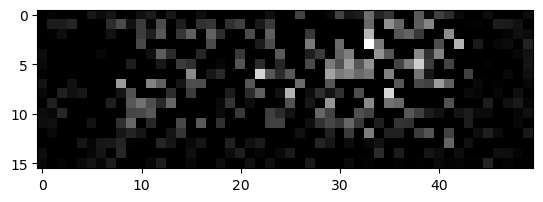

In [304]:
plt.imshow(out[0, 8].detach(), cmap="gray")

In [314]:
lens = [len(train_dataset[i][1]) for i in tqdm(range(len(train_dataset)))]

  0%|          | 0/169983 [00:00<?, ?it/s]

In [315]:
lens = np.array(lens)

In [317]:
lens.min()

7

In [318]:
400 / 25 * 

16.0

In [1]:
torchvision

NameError: name 'torchvision' is not defined

In [81]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: 
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Model(nn.Module):
    def __init__(self, in_channels, vocab_len_1, vocab_len_2):
        super().__init__()
        self.conv1 = conv_block(in_channels, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop1 = nn.Dropout(0.5)

        self.conv2 = conv_block(64, 64, pool=True)
        self.res2 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop2 = nn.Dropout(0.5)

        self.conv3 = conv_block(64, 64, pool=True)
        self.res3 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop3 = nn.Dropout(0.5)

        self.conv4 = conv_block(64, 64, pool=True)
        self.res4 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop4 = nn.Dropout(0.5)

        self.max_pool = nn.MaxPool2d(4)
        self.flatten = nn.Flatten(start_dim=1, end_dim=-2)
        self.linear1 = nn.Linear(12, 6)
        self.relu = nn.ReLU()

#         self.linear2 = nn.Linear(256, vocab_len_1)
        self.linear3 = nn.Linear(256, vocab_len_2)

        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, inp):
        out = self.conv1(inp)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.drop2(out)

        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.drop3(out)

        out = self.max_pool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.relu(out)

#         out_1 = self.softmax(self.linear2(out[:, :, 0]))
        out_2 = self.softmax(self.linear3(out[:, :, 0:].transpose(1, 2)))
        
        return out_2

In [82]:
n_epochs = 10
device = torch.device(device='cuda')
model = Model(in_channels=1, vocab_len_1=vocab_len_1, vocab_len_2=vocab_len_2).to(device)
# model = resnet101(pretrained=True).to(device)
# model.fc = nn.Linear(2048, 2)
# model = ResNet(in_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [83]:
model(a[0].to(device) / 255)

tensor([[[0.0116, 0.0169, 0.0501,  ..., 0.0248, 0.0189, 0.0057],
         [0.0264, 0.0263, 0.0267,  ..., 0.0270, 0.0272, 0.0271],
         [0.0211, 0.0256, 0.0265,  ..., 0.0246, 0.0250, 0.0210],
         [0.0011, 0.0016, 0.0034,  ..., 0.0088, 0.0171, 0.0016],
         [0.0191, 0.0216, 0.0400,  ..., 0.0283, 0.0333, 0.0199],
         [0.0190, 0.0284, 0.0245,  ..., 0.0252, 0.0298, 0.0301]],

        [[0.0049, 0.0016, 0.0363,  ..., 0.1351, 0.0028, 0.0147],
         [0.0264, 0.0266, 0.0267,  ..., 0.0269, 0.0272, 0.0276],
         [0.0300, 0.0269, 0.0232,  ..., 0.0281, 0.0263, 0.0290],
         [0.0018, 0.0029, 0.0121,  ..., 0.0031, 0.0147, 0.0460],
         [0.0307, 0.0212, 0.0276,  ..., 0.0240, 0.0204, 0.0242],
         [0.0189, 0.0333, 0.0207,  ..., 0.0202, 0.0286, 0.0265]],

        [[0.0168, 0.0111, 0.0668,  ..., 0.0459, 0.0222, 0.0642],
         [0.0257, 0.0260, 0.0273,  ..., 0.0271, 0.0280, 0.0267],
         [0.0264, 0.0262, 0.0268,  ..., 0.0268, 0.0272, 0.0272],
         [0.0040, 0.0

In [89]:
help(criterion)

Help on CrossEntropyLoss in module torch.nn.modules.loss object:

class CrossEntropyLoss(_WeightedLoss)
 |  CrossEntropyLoss(weight: Optional[torch.Tensor] = None, size_average=None, ignore_index: int = -100, reduce=None, reduction: str = 'mean', label_smoothing: float = 0.0) -> None
 |  
 |  This criterion computes the cross entropy loss between input logits
 |  and target.
 |  
 |  It is useful when training a classification problem with `C` classes.
 |  If provided, the optional argument :attr:`weight` should be a 1D `Tensor`
 |  assigning weight to each of the classes.
 |  This is particularly useful when you have an unbalanced training set.
 |  
 |  The `input` is expected to contain the unnormalized logits for each class (which do `not` need
 |  to be positive or sum to 1, in general).
 |  `input` has to be a Tensor of size :math:`(C)` for unbatched input,
 |  :math:`(minibatch, C)` or :math:`(minibatch, C, d_1, d_2, ..., d_K)` with :math:`K \geq 1` for the
 |  `K`-dimensional ca

In [92]:
import random
from datetime import timedelta
import time
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm
# device = torch.device("cuda")
seed = 42

random.seed = (seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
model.cuda()

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    print("Training {} epoch".format(epoch + 1))
    start = time.time()
    mean_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if (step + 1) % 50 == 0:
            duration = timedelta(seconds=int(time.time() - start))
            print('Batch {:>5,}  of  {:>5,}. Loss {:.3}  Time: {:}.'.format(step + 1, len(train_dataloader), mean_loss / step, duration))
        
        torch.cuda.empty_cache()
        b_input = (batch[0] / 255).to(device)
        b_labels_1 = batch[1].to(device)
        b_lables_2 = torch.concat(batch[2]).to(device)
        model.zero_grad()
        
        
        torch.cuda.empty_cache()
        output = model(b_input / 255)
        
        loss = criterion(output.view(-1, 36), b_lables_2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
        print(loss.item())
        
    mean_loss = mean_loss / len(train_dl)
    
    train_losses.append(mean_loss)
    print("Mean loss: " , mean_loss)
    print("Training epoch took:" , timedelta(seconds=int(time.time() - start)))
    
    print()
    print("Validation:")
    model.eval()
    
    start = time.time()
    predictions = torch.Tensor().to(dtype=torch.int8)
    val_loss = 0
    
    for batch in val_dataloader:
        
        b_input = batch[0].to(device)
        b_labels_1 = batch[1]
        b_lables_2 = batch[2]
        
        
        
        with torch.no_grad():
            output = model(b_input)
            val_loss = criterion(out[1].view(-1, 36), torch.concat(b_lables_2)).item()
#         predictions = torch.cat((predictions, torch.argmax(output, dim=1).cpu().detach()))
        predictions = torch.cat((predictions, output.round().view(-1).cpu().detach()))
        torch.cuda.empty_cache()
        
    print("Mean loss: " , val_loss / len(val_dl))
    print("Accuracy {:4.2f}".format(accuracy_score(y_val, predictions.round())))
    print("Precision {:4.2f}, recall {:4.2f}, F1 {:4.2f}".format(*[a(y_val, predictions.round()) 
                                                                   for a in (precision_score, recall_score, f1_score)]))
    val_losses.append(val_loss / len(val_dl))
    print("Validation took: {:}".format(timedelta(seconds = int(time.time() - start))))
    print()

Training 1 epoch
3.4791042804718018
3.484257698059082
3.463473320007324
3.473896026611328
3.4530622959136963
3.4895193576812744
3.4686901569366455
3.473900079727173
3.4739129543304443
3.47910475730896
3.463479995727539
3.489527463912964
3.4530646800994873
3.479104995727539
3.473329782485962
3.473910093307495
3.4634857177734375
3.468717336654663
3.479098081588745
3.4686596393585205
3.4634780883789062
3.452925682067871
3.479111433029175
3.468686819076538
3.4686834812164307
3.4685933589935303
3.447838544845581
3.4530751705169678
3.4738969802856445
3.4791221618652344
3.4686872959136963
3.4530627727508545
3.4687016010284424
3.447833776473999
3.48952317237854
3.4738929271698
3.4478492736816406
3.453063726425171
3.4582700729370117
3.46868634223938
3.4686880111694336
3.463470697402954
3.4738852977752686
3.4634809494018555
3.4895193576812744
3.4686853885650635
3.4426565170288086
3.479100227355957
3.453063726425171
Batch    50  of  5,312. Loss 3.47  Time: 0:00:08.
3.468700408935547
3.48952674865

3.479105234146118
3.473896026611328
3.447852373123169
3.473896026611328
3.4686872959136963
3.4738948345184326
3.4634790420532227
3.4634788036346436
3.458271026611328
3.458271026611328
3.458268880844116
3.473895788192749
3.463488817214966
3.4686830043792725
3.458270788192749
3.468687057495117
3.484312057495117
3.4634783267974854
3.4634788036346436
3.4686880111694336
3.4791042804718018
3.4634907245635986
3.458270311355591
3.4478542804718018
3.46347975730896
3.4686877727508545
3.4478542804718018
3.46868896484375
Batch   450  of  5,312. Loss 3.47  Time: 0:01:30.
3.4791040420532227
3.4530622959136963
3.468687057495117
3.46347975730896
3.468687057495117
3.458270311355591
3.4686877727508545
3.458270311355591
3.447854995727539
3.4478533267974854
3.463480234146118
3.4738962650299072
3.473895788192749
3.4738969802856445
3.463479995727539
3.4791042804718018
3.4530622959136963
3.4791038036346436
3.4582760334014893
3.4582712650299072
3.473895311355591
3.4738962650299072
3.47389817237854
3.468688011

3.4686877727508545
3.4478542804718018
3.473896026611328
3.4843130111694336
3.4686877727508545
3.4634790420532227
3.484312057495117
Batch   850  of  5,312. Loss 3.47  Time: 0:02:56.
3.4686899185180664
3.4634790420532227
3.468687057495117
3.442646026611328
3.46347975730896
3.4530630111694336
3.4530630111694336
3.4791038036346436
3.4634792804718018
3.4634792804718018
3.4738941192626953
3.47910475730896
3.458271026611328
3.4478540420532227
3.4686872959136963
3.473896026611328
3.4530630111694336
3.4686872959136963
3.47910475730896
3.4582712650299072
3.4582712650299072
3.47910475730896
3.4686880111694336
3.4738972187042236
3.4686880111694336
3.46347975730896
3.458270788192749
3.46347975730896
3.4530622959136963
3.4738962650299072
3.4686880111694336
3.473895788192749
3.468684196472168
3.4426450729370117
3.4843130111694336
3.46868896484375
3.4843122959136963
3.4686880111694336
3.4634792804718018
3.4738962650299072
3.46347975730896
3.473896026611328
3.458271026611328
3.453063726425171
3.4738957

3.458271026611328
3.4530632495880127
3.4738962650299072
3.4686880111694336
3.4686872959136963
3.4738962650299072
3.4634792804718018
3.4634792804718018
3.4686880111694336
3.473895788192749
3.473896026611328
3.463484048843384
3.4738962650299072
3.4791042804718018
3.473896026611328
3.46347975730896
3.46347975730896
3.47910475730896
3.463479995727539
3.4738962650299072
3.4530630111694336
3.46347975730896
3.453062057495117
3.4686877727508545
3.4738962650299072
3.479105234146118
3.473896026611328
3.4791042804718018
3.4947288036346436
3.4634792804718018
3.4634792804718018
3.4582712650299072
3.458271026611328
3.4686877727508545
3.4686880111694336
3.4738962650299072
3.46347975730896
3.4686877727508545
3.4791042804718018
Batch 1,300  of  5,312. Loss 3.47  Time: 0:04:34.
3.46347975730896
3.473896026611328
3.458271026611328
3.4738948345184326
3.4738962650299072
3.4478542804718018
3.47910475730896
3.473896026611328
3.4582712650299072
3.4738962650299072
3.46347975730896
3.4738962650299072
3.47910428

3.4426462650299072
3.4843130111694336
3.4999380111694336
3.4895212650299072
3.4530630111694336
3.4530630111694336
3.4582700729370117
3.473896026611328
3.46347975730896
3.4686877727508545
3.473895788192749
3.44785475730896
3.489521026611328
3.4582679271698
3.4895212650299072
3.4478542804718018
3.4582712650299072
Batch 1,700  of  5,312. Loss 3.47  Time: 0:06:01.
3.47910475730896
3.4582712650299072
3.4634792804718018
3.458271026611328
3.46347975730896
3.4426462650299072
3.4530630111694336
3.4738962650299072
3.4999380111694336
3.4895212650299072
3.47910475730896
3.4843127727508545
3.4634792804718018
3.473896026611328
3.4843132495880127
3.4582712650299072
3.47910475730896
3.47910475730896
3.4686877727508545
3.4530630111694336
3.46347975730896
3.4530627727508545
3.4686872959136963
3.4686877727508545
3.4843132495880127
3.4843130111694336
3.4530627727508545
3.4582712650299072
3.4634792804718018
3.4791042804718018
3.46347975730896
3.4843127727508545
3.473896026611328
3.484314203262329
3.4634792

3.4791042804718018
3.473896026611328
3.4634792804718018
3.4634792804718018
3.47910475730896
3.4530630111694336
3.4530627727508545
3.4843130111694336
3.44785475730896
3.4738962650299072
3.4686880111694336
3.4530630111694336
3.46347975730896
3.4843127727508545
3.44785475730896
3.47910475730896
3.47910475730896
3.4582712650299072
3.46347975730896
3.4686880111694336
3.489521026611328
3.4530630111694336
3.46347975730896
3.4582712650299072
3.4530630111694336
3.4791042804718018
3.4686880111694336
3.473895311355591
3.46347975730896
3.4686880111694336
3.4686880111694336
3.4738962650299072
3.46347975730896
3.46347975730896
3.473895788192749
3.4634809494018555
3.4738962650299072
3.458271026611328
3.4582712650299072
3.4686880111694336
3.4686880111694336
3.47910475730896
3.46347975730896
3.47910475730896
3.47910475730896
3.46347975730896
3.473896026611328
3.46347975730896
3.4686880111694336
Batch 2,150  of  5,312. Loss 3.47  Time: 0:07:38.
3.4738962650299072
3.4582712650299072
3.4426472187042236
3.

3.4791042804718018
3.47910475730896
3.47910475730896
3.4478542804718018
3.4634792804718018
3.4843130111694336
3.4582712650299072
3.4686901569366455
3.4738962650299072
3.463479995727539
3.4582712650299072
3.46347975730896
3.47910475730896
3.46347975730896
3.4843130111694336
3.4738962650299072
3.47910475730896
3.4843130111694336
3.44785475730896
3.4738962650299072
3.46347975730896
3.4686880111694336
3.458271026611328
Batch 2,550  of  5,312. Loss 3.47  Time: 0:09:05.
3.458271026611328
3.4582712650299072
3.4530630111694336
3.4686877727508545
3.4686880111694336
3.44785475730896
3.46347975730896
3.4582712650299072
3.4634792804718018
3.4686882495880127
3.479105234146118
3.4791042804718018
3.4530630111694336
3.4791042804718018
3.47910475730896
3.4686880111694336
3.4738962650299072
3.46347975730896
3.427021026611328
3.4634792804718018
3.4686896800994873
3.46347975730896
3.4686880111694336
3.4582712650299072
3.4843130111694336
3.46347975730896
3.4738962650299072
3.46347975730896
3.44785475730896

3.4530630111694336
3.4686877727508545
3.4843130111694336
3.4895212650299072
3.46347975730896
3.4582712650299072
3.4582712650299072
3.46347975730896
3.4843130111694336
3.4582712650299072
3.4843127727508545
3.4478542804718018
3.44785475730896
3.4582712650299072
3.4530630111694336
3.4843127727508545
3.4686880111694336
3.47910475730896
3.4582712650299072
3.4530630111694336
3.4686880111694336
3.458271026611328
3.4686880111694336
3.4582712650299072
3.4738967418670654
3.4686880111694336
3.4582712650299072
3.4582712650299072
3.4582712650299072
3.46347975730896
3.4530627727508545
3.4686880111694336
3.4843130111694336
3.47910475730896
3.4582712650299072
3.4686877727508545
3.4530630111694336
3.4686880111694336
3.4686880111694336
3.458271026611328
3.4738962650299072
3.4582712650299072
3.44785475730896
3.4686880111694336
3.44785475730896
3.4686880111694336
3.4738962650299072
3.4686880111694336
3.4686880111694336
3.4738962650299072
Batch 3,000  of  5,312. Loss 3.47  Time: 0:10:46.
3.47910475730896
3

3.4686880111694336
3.44785475730896
3.47910475730896
3.4582712650299072
3.4426462650299072
3.4530630111694336
3.4686880111694336
3.4686880111694336
3.4895212650299072
3.47910475730896
3.4686880111694336
3.4686880111694336
3.4791042804718018
3.4530630111694336
3.46347975730896
3.46347975730896
3.4530630111694336
3.4686880111694336
3.4582712650299072
3.4738967418670654
3.4582712650299072
3.4530630111694336
3.458271026611328
3.4895212650299072
3.4738962650299072
3.4530630111694336
Batch 3,400  of  5,312. Loss 3.47  Time: 0:12:21.
3.46347975730896
3.4738962650299072
3.458271026611328
3.46347975730896
3.46347975730896
3.4582712650299072
3.4686880111694336
3.47910475730896
3.46347975730896
3.4426467418670654
3.46347975730896
3.4686880111694336
3.4686880111694336
3.4843130111694336
3.4582712650299072
3.4686877727508545
3.4738962650299072
3.46347975730896
3.4582712650299072
3.4843130111694336
3.473896026611328
3.4738962650299072
3.4582719802856445
3.4686880111694336
3.46347975730896
3.46347975

3.4843130111694336
3.47910475730896
Batch 3,800  of  5,312. Loss 3.47  Time: 0:13:59.
3.4582712650299072
3.47910475730896
3.4738962650299072
3.4582712650299072
3.4843130111694336
3.4582712650299072
3.4686880111694336
3.4738962650299072
3.4582712650299072
3.4738962650299072
3.4582712650299072
3.4738962650299072
3.47910475730896
3.46347975730896
3.4686880111694336
3.4738962650299072
3.46347975730896
3.4530630111694336
3.4738962650299072
3.4738962650299072
3.46347975730896
3.46347975730896
3.4686880111694336
3.46347975730896
3.46347975730896
3.46347975730896
3.4895212650299072
3.4843130111694336
3.44785475730896
3.46347975730896
3.4895212650299072
3.4843130111694336
3.4530630111694336
3.46347975730896
3.4895212650299072
3.4582712650299072
3.4530630111694336
3.4686880111694336
3.44785475730896
3.4738962650299072
3.46347975730896
3.4738962650299072
3.46347975730896
3.4738962650299072
3.44785475730896
3.4895212650299072
3.4582712650299072
3.458271026611328
3.4738962650299072
3.47389626502990

3.4738962650299072
3.4582712650299072
3.46347975730896
3.47910475730896
3.46347975730896
3.47910475730896
3.4686880111694336
3.47910475730896
3.4582712650299072
3.4686880111694336
3.4530630111694336
3.4530630111694336
3.4582712650299072
3.46347975730896
3.4738962650299072
3.4738962650299072
3.4582712650299072
3.4686880111694336
3.46347975730896
3.44785475730896
3.4738962650299072
3.4686880111694336
3.458271026611328
3.4738962650299072
3.4738962650299072
3.46347975730896
3.46347975730896
3.4582712650299072
3.46347975730896
3.46347975730896
3.46347975730896
Batch 4,250  of  5,312. Loss 3.47  Time: 0:15:52.
3.4738962650299072
3.4530630111694336
3.4686880111694336
3.4686880111694336
3.4374380111694336
3.4582712650299072
3.44785475730896
3.44785475730896
3.4738962650299072
3.4530630111694336
3.4582712650299072
3.4686880111694336
3.47910475730896
3.4686880111694336
3.4530630111694336
3.47910475730896
3.4738962650299072
3.442646026611328
3.4530630111694336
3.4634788036346436
3.46347975730896


3.47910475730896
3.4738962650299072
3.4738962650299072
3.44785475730896
3.4843130111694336
Batch 4,650  of  5,312. Loss 3.47  Time: 0:17:33.
3.4791042804718018
3.4686877727508545
3.4895212650299072
3.4530630111694336
3.4686880111694336
3.4582712650299072
3.4530630111694336
3.4582712650299072
3.47910475730896
3.4582712650299072
3.4530630111694336
3.4738962650299072
3.47910475730896
3.4582712650299072
3.47910475730896
3.44785475730896
3.479104995727539
3.4426462650299072
3.4530627727508545
3.4686880111694336
3.4582712650299072
3.4426462650299072
3.4530630111694336
3.47910475730896
3.4686882495880127
3.46347975730896
3.46347975730896
3.4843130111694336
3.4582712650299072
3.4582712650299072
3.4686880111694336
3.4530630111694336
3.46347975730896
3.47910475730896
3.4634792804718018
3.4686880111694336
3.4686880111694336
3.4686880111694336
3.4686877727508545
3.4582712650299072
3.4530630111694336
3.4582712650299072
3.47910475730896
3.4895212650299072
3.47910475730896
3.473896026611328
3.4686880

3.4530630111694336
3.4738962650299072
3.4843130111694336
3.4582712650299072
3.47910475730896
3.4686880111694336
3.4686880111694336
3.4999380111694336
3.4686880111694336
3.4582712650299072
3.4582712650299072
3.4843130111694336
3.4686880111694336
3.46347975730896
3.4738962650299072
3.4686880111694336
3.46347975730896
3.46347975730896
3.4374380111694336
3.47910475730896
3.4582712650299072
3.4686880111694336
3.4686877727508545
3.4530630111694336
3.46347975730896
3.4582712650299072
3.47910475730896
3.46347975730896
3.4374380111694336
3.4530630111694336
3.4426462650299072
3.4686880111694336
3.4530630111694336
Batch 5,100  of  5,312. Loss 3.47  Time: 0:19:27.
3.4738962650299072
3.46347975730896
3.46347975730896
3.4686880111694336
3.4738962650299072
3.4530630111694336
3.46347975730896
3.4530630111694336
3.44785475730896
3.4582712650299072
3.4530630111694336
3.4686880111694336
3.4582712650299072
3.4738962650299072
3.4582712650299072
3.4686880111694336
3.47910475730896
3.4843130111694336
3.46347

NameError: name 'train_dl' is not defined

In [94]:
output

3.466261319367282

In [410]:
model

Model()

In [407]:
model = Model(in_channels=1, vocab_len_1=vocab_len_1, vocab_len_2=vocab_len_2)

In [409]:
model(a[0] / 255)

(tensor([[2.0985e-02, 2.2619e-02, 4.3685e-02, 2.3674e-02, 5.9634e-02, 2.5938e-03,
          2.1693e-02, 1.4273e-03, 8.1580e-03, 1.4425e-01, 4.6196e-02, 3.5237e-02,
          1.5213e-02, 1.1161e-02, 2.8959e-03, 3.5930e-03, 1.8042e-02, 8.6157e-03,
          1.8371e-02, 1.0414e-03, 2.1725e-03, 1.2099e-01, 2.8068e-03, 5.9793e-02,
          1.5066e-02, 3.1931e-02, 6.9133e-02, 2.0022e-02, 1.6899e-02, 2.0972e-02,
          1.3113e-01],
         [1.8106e-02, 4.2454e-02, 9.3702e-03, 1.8622e-03, 6.5325e-02, 5.2889e-03,
          2.7370e-02, 2.1337e-03, 4.7101e-03, 2.2845e-01, 5.1061e-02, 1.3287e-02,
          1.1177e-02, 1.1555e-02, 2.3992e-03, 6.5429e-03, 5.0437e-02, 8.3825e-03,
          1.8341e-02, 4.0836e-04, 1.1418e-02, 3.1200e-02, 2.2626e-03, 1.1804e-02,
          5.8717e-03, 8.7320e-02, 4.5316e-02, 1.1805e-02, 2.5386e-02, 1.1383e-01,
          7.5130e-02],
         [2.9427e-02, 3.1756e-02, 2.3573e-02, 8.9245e-03, 4.5273e-02, 8.5319e-03,
          2.1852e-02, 5.0894e-03, 1.4500e-02, 1.3213

In [215]:
[(means[2:] > means[1:-1]) & (means[:-2] > means[1:-1])]

[tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False,  True, False, False, False, False, False,  True,
         False, False, False, False, False, False, False,  True, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True, False,
         False, False, False, False, False, False, F

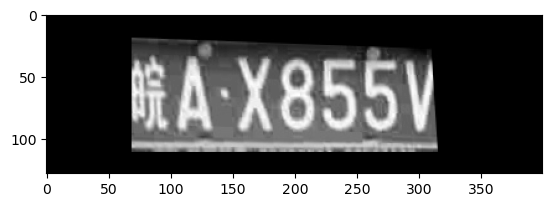

In [201]:
plt.imshow(a[0][30].permute(1, 2, 0), cmap="gray")

In [156]:
cv2.bilateralFilter(np.array(img), d=4, sigmaColor=0.1, sigmaSpace=0)

error: OpenCV(4.6.0) C:\b\abs_74oeeuevib\croots\recipe\opencv-suite_1664548340488\work\modules\imgproc\src\bilateral_filter.dispatch.cpp:166: error: (-215:Assertion failed) (src.type() == CV_8UC1 || src.type() == CV_8UC3) && src.data != dst.data in function 'cv::bilateralFilter_8u'


In [158]:
img > cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

In [24]:
sizes = [x[0].shape for x in train_dataset]

In [27]:
sizes = np.array(sizes)

In [35]:
np.quantile(sizes, 0.98, axis=0)

array([126., 392.,   3.])

In [36]:
(sizes[:, 1] <= 400).mean()

0.983586593953513

(array([5.000e+00, 8.000e+00, 2.700e+01, 8.000e+01, 1.850e+02, 1.860e+02,
        3.580e+02, 4.340e+02, 6.150e+02, 7.160e+02, 9.590e+02, 1.504e+03,
        1.747e+03, 2.693e+03, 2.851e+03, 3.962e+03, 4.102e+03, 5.449e+03,
        5.311e+03, 5.743e+03, 7.495e+03, 6.783e+03, 8.341e+03, 7.428e+03,
        8.616e+03, 7.284e+03, 8.050e+03, 6.739e+03, 7.586e+03, 6.191e+03,
        5.731e+03, 6.254e+03, 5.043e+03, 5.258e+03, 4.088e+03, 4.451e+03,
        3.294e+03, 3.350e+03, 2.579e+03, 2.335e+03, 2.369e+03, 1.848e+03,
        1.895e+03, 1.361e+03, 1.457e+03, 1.038e+03, 1.082e+03, 7.800e+02,
        7.740e+02, 5.000e+02, 3.880e+02, 3.630e+02, 2.610e+02, 2.490e+02,
        1.970e+02, 2.430e+02, 1.680e+02, 1.640e+02, 1.410e+02, 1.100e+02,
        1.110e+02, 9.900e+01, 1.020e+02, 7.200e+01, 6.700e+01, 5.000e+01,
        5.800e+01, 3.800e+01, 3.100e+01, 2.200e+01, 1.800e+01, 1.400e+01,
        1.300e+01, 1.100e+01, 8.000e+00, 1.300e+01, 7.000e+00, 3.000e+00,
        6.000e+00, 4.000e+00, 4.000e+0

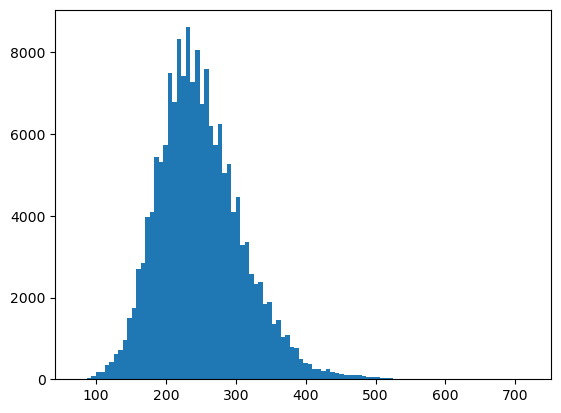

In [113]:
plt.hist(sizes[:, 1], bins=100)

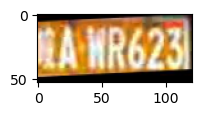

In [60]:
plt.figure(figsize=(2, 1))
plt.imshow(train_dataset[2234][0])

In [9]:
def encode(text):
    length = []
    result = []
    for item in text:
        # item = item.decode('utf-8', 'strict')
        length.append(len(item))
        for char in item:
            if char in symbol_map:
                index = symbol_map[char]
            else:
                index = 0
            result.append(index)

    text = result
    return (torch.IntTensor(text), torch.IntTensor(length))

In [35]:
val_dataset[8721]

(tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 '皖A230L2')

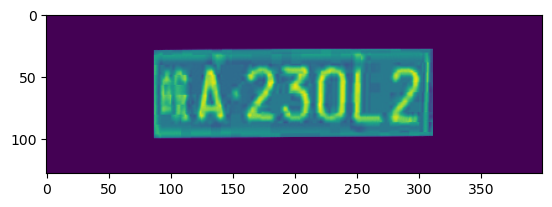

In [36]:
plt.imshow(val_dataset[8721][0].permute(1, 2, 0))

In [223]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

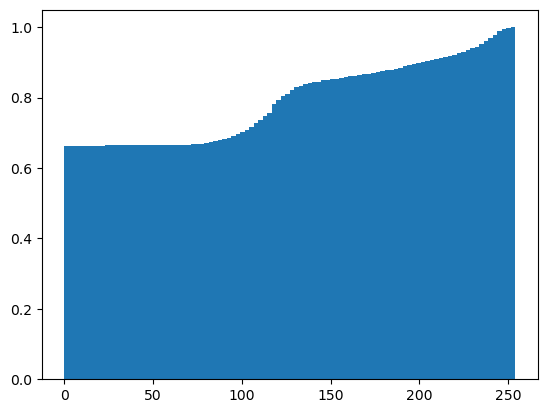

In [327]:
plt.hist(img.view(-1), bins=100, cumulative=True, density=True);

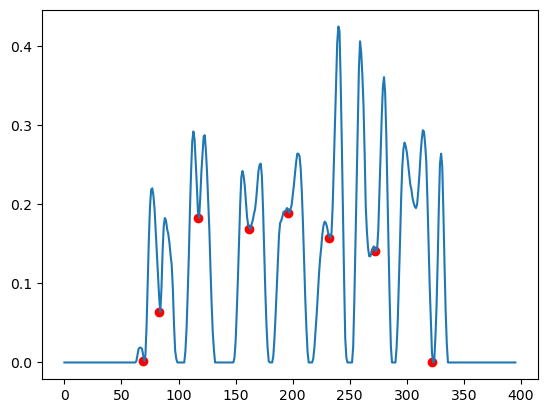

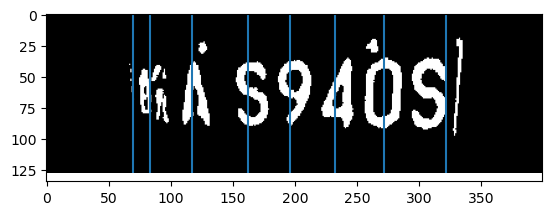

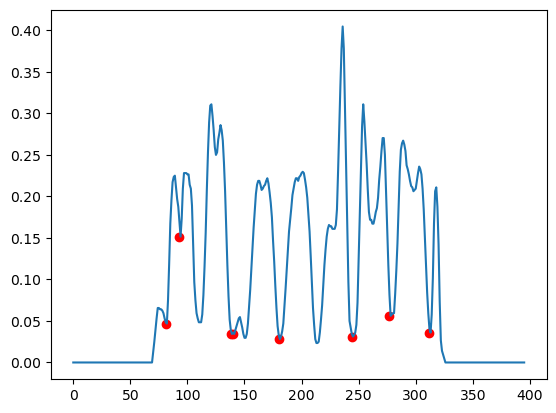

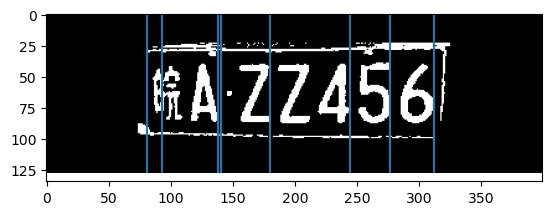

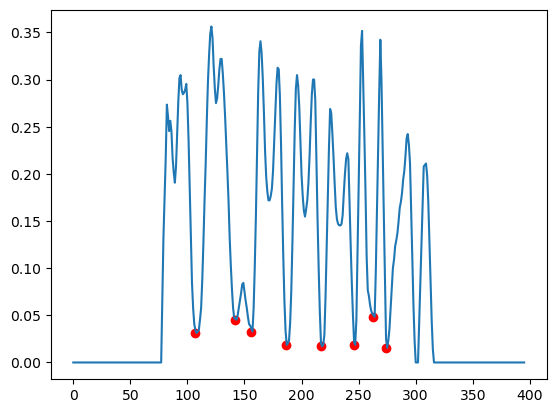

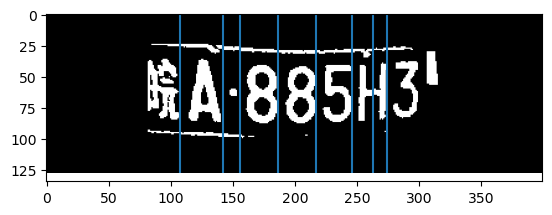

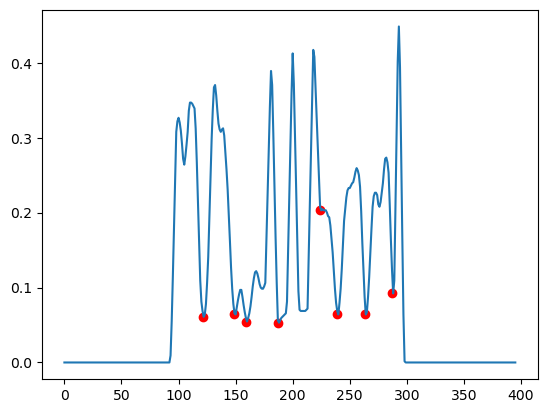

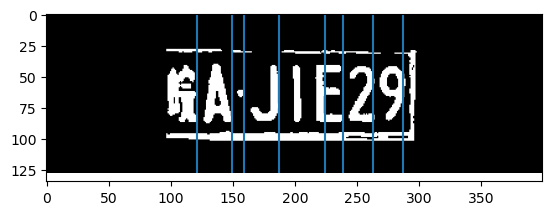

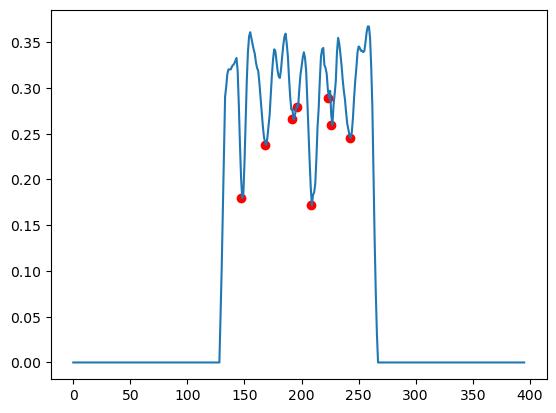

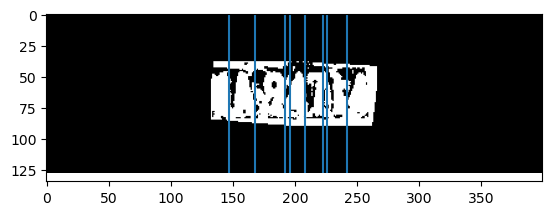

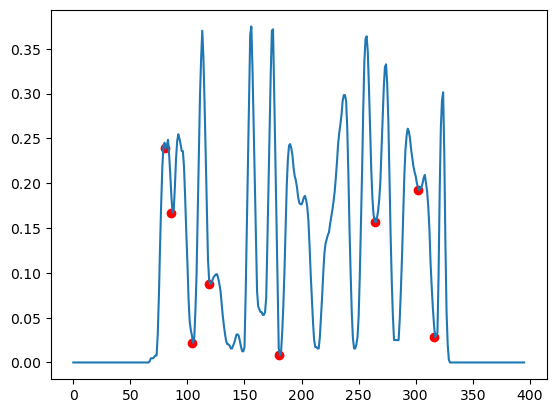

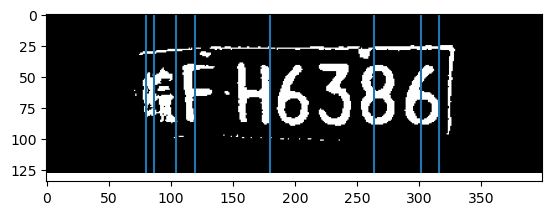

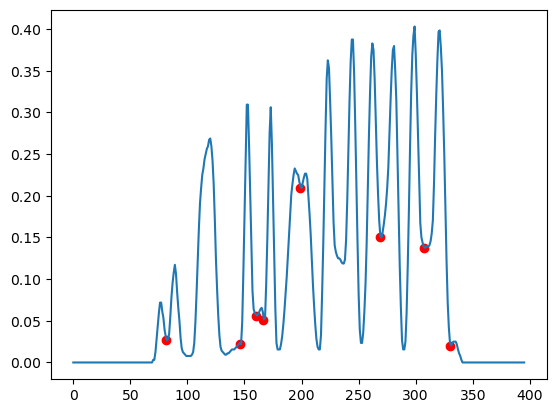

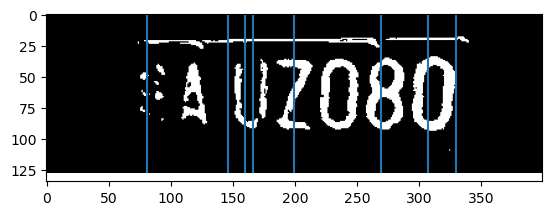

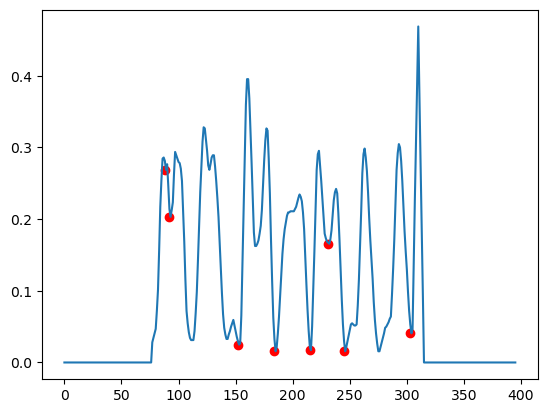

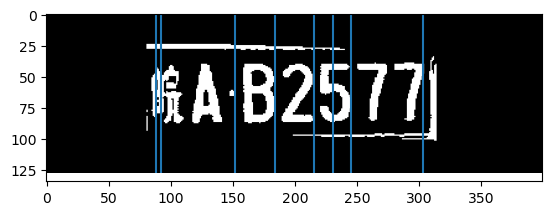

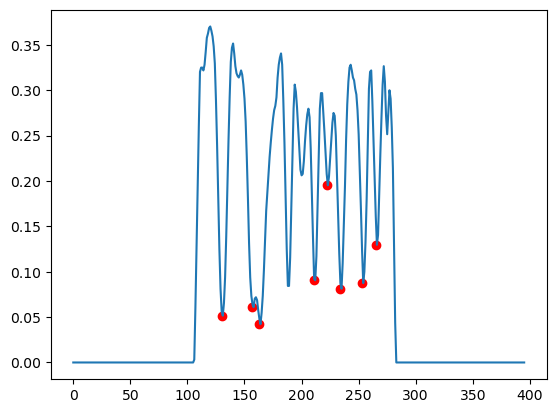

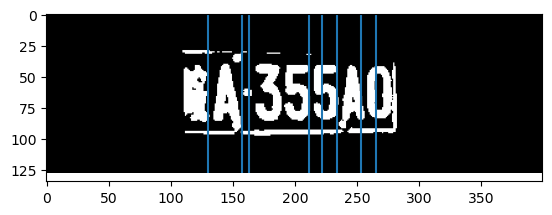

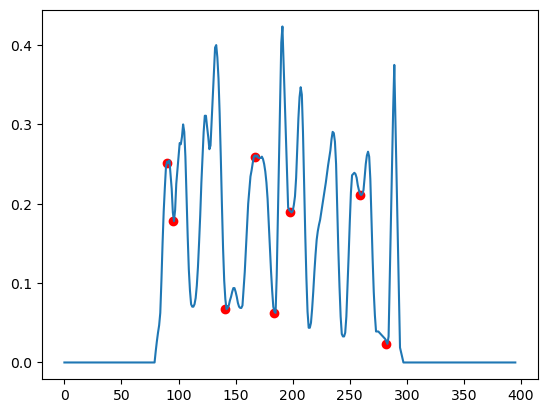

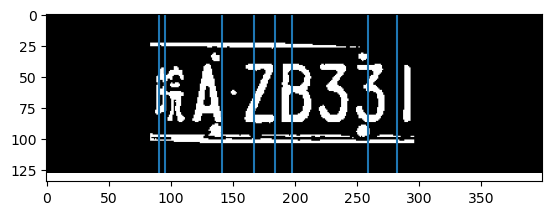

In [328]:
for i in range(10):
    img = a[0][i]
    q = np.quantile(img.view(-1), 0.9)
    img = img > q
    means = torch.mean(img.to(dtype=torch.float32), dim=1)[0]
    # plt.plot(np.arange(len(means)), means)

    means = moving_average(means, 5)
    plt.plot(np.arange(len(means)), means)

    local_min_idxs = np.arange(len(means) - 2)[(means[2:] > means[1:-1]) & (means[:-2] > means[1:-1])]
    local_min_idxs = local_min_idxs[np.argsort(means[1:-1][local_min_idxs])[:8]]
    local_mins = means[1:-1][local_min_idxs]
    plt.scatter(local_min_idxs, local_mins, c="r")
    plt.show()

    # plt.plot(np.arange(len(means) - 1), means.diff())
    # plt.ylim(-10, 10)
    # plt.show()

    plt.imshow(img.permute(1, 2, 0), cmap="gray")
    plt.vlines(local_min_idxs, ymin=0, ymax=128)
    plt.show()